# The utilization of TRIUMF site
This code will read from job archive table in ES and ...

In [71]:
sites_info={}
sites_info["AGLT2"]={}
sites_info["AGLT2"]["ncore"]=10224
sites_info["AGLT2"]["mh"]="modificationhost:(/.*aglt2.org/)"

sites_info["BEIJING"]={}
sites_info["BEIJING"]["ncore"]=468
#sites_info["BEIJING"]["mh"]="modificationhost:(/.*lwn1[2-4][0-9].*ihep.ac.cn/ OR /.*lwn15[0-2].ihep.ac.cn/ )"
sites_info["BEIJING"]["mh"]="modificationhost:(/.*lwn.*ihep.ac.cn/)"

sites_info["BEIJING_SCORE"]={}
sites_info["BEIJING_SCORE"]["ncore"]=72
sites_info["BEIJING_SCORE"]["mh"]="modificationhost:(/.*lwn12[4-7,9].ihep.ac.cn/ OR /.*lwn130.ihep.ac.cn/)"


sites_info["BEIJING_MCORE"]={}
sites_info["BEIJING_MCORE"]["ncore"]=384
sites_info["BEIJING_MCORE"]["mh"]="modificationhost:(/.*lwn13[1-9].ihep.ac.cn/ OR /.*lwn14[0-9].ihep.ac.cn/ OR /.*lwn15[0-2].ihep.ac.cn/)"

sites_info["TRIUMF"]={}
sites_info["TRIUMF"]["ncore"]=4816
sites_info["TRIUMF"]["mh"]="modificationhost:(/.*wn.*triumf.lcg/)"

sites_info["TOKYO"]={}
sites_info["TOKYO"]["ncore"]=6144
sites_info["TOKYO"]["mh"]="modificationhost:(/.*jp/)"

sites_info["SiGNET"]={}
sites_info["SiGNET"]["ncore"]=6460
sites_info["SiGNET"]["mh"]="modificationhost:(/.*ijs.si/)"

sites_info["MWT2"]={}
sites_info["MWT2"]["ncore"]=16250
sites_info["MWT2"]["mh"]="modificationhost:(/.*mwt2.org/)"


In [72]:
this_site="BEIJING"
last_days=7
end_days_ago=0

In [73]:
%matplotlib inline
import datetime
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
import time
from pandas.plotting import table
import os

from elasticsearch import Elasticsearch, helpers



avail_cpu=sites_info[this_site]["ncore"]
mh=sites_info[this_site]["mh"]



es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')

indices = sorted(indices)
indices = [x for x in indices if x != '' and not x.endswith('_reindexed')]

def time_filter(indices, last_days=1):
    if last_days == 0:
        return ["jobs_archive_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days < last_days:
            filtered.append(i.rstrip())
    return filtered

#ind = time_filter(indices, last_days)
ind = time_filter(indices, 0)
print ("number of indices:", len(ind))
ind = ','.join(ind)
ltime=time.localtime()
etime=int(time.time()*1000)-3600*24*1000*end_days_ago-(ltime[3]*3600+ltime[4]*60+ltime[5])*1000
#stime=etime-3600*24*last_days*1000+3600*1000
stime=etime-3600*24*last_days*1000
true="true"
false="false"
my_query={
  "size": 0,
  "version": true,
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": mh,
            "analyze_wildcard": true,
            "lowercase_expanded_terms": false
          }
        },
        {
          "range": {
            "modificationtime": {
              "gte": stime,
              "lte": etime,
              "format": "epoch_millis"
            }
          }
        }
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "terms": {
        "field": "computingsite",
        "size": 10,
        "order": {
          "_term": "desc"
        }
      },
      "aggs": {
        "4": {
          "terms": {
            "field": "jobstatus",
            "size": 5,
            "order": {
              "_count": "desc"
            }
          },
          "aggs": {
            "5": {
              "sum": {
                "script": {
                  "inline": "double core=doc['actualcorecount'].value; double wall_time=doc['wall_time'].value;if (core>0) {return (wall_time * core)/(3600*24)} else {return (wall_time)/(3600*24)}",
                  "lang": "painless"
                }
              }
            },
            "6": {
              "sum": {
                "script": {
                  "inline": "double max_cpu_per_event=2000;double cpusec=doc['cpuconsumptiontime'].value; String site=doc['computingsite'].value;double nevents=doc[\"nevents\"].value;if (site==\"BOINC_MCORE\" && (cpusec>max_cpu_per_event*nevents || cpusec<0)) {return max_cpu_per_event*nevents/(3600*24)} else {return cpusec/(3600*24)}",
                  "lang": "painless"
                }
              }
            }
          }
        }
      }
    }
  },
  "_source": {
    "excludes": []
  },
  "highlight": {
    "pre_tags": [
      "@kibana-highlighted-field@"
    ],
    "post_tags": [
      "@/kibana-highlighted-field@"
    ],
    "fields": {
      "*": {
        "highlight_query": {
          "bool": {
            "must": [
              {
                "query_string": {
                  "query": mh,
                  "analyze_wildcard": true,
                  "lowercase_expanded_terms": false,
                  "all_fields": true
                }
              },
              {
                "range": {
                  "modificationtime": {
                    "gte": stime,
                    "lte": etime,
                    "format": "epoch_millis"
                  }
                }
              }
            ],
            "must_not": []
          }
        }
      }
    },
    "fragment_size": 2147483647
  }
}
res=es.search(index=ind, body=my_query, request_timeout=12000)

site_res={}
status_key=["finished","failed"]
metric_key=["cn","cputime","walltime"]
for metric in metric_key:
    for status in status_key:
        site_res[metric+"_"+status]={}
    
buckets=res['aggregations']['2']['buckets']


for i in range(len(buckets)):
    sitename=buckets[i]['key']
    for st in status_key:
        for m in ["cputime","walltime","cn"]:
            site_res[m+"_"+st][sitename]=0
    #site_res[sitename]={}
    bs=buckets[i]["4"]["buckets"]
    for j in range(len(bs)):
        status=bs[j]['key']
        if status not in status_key:
            continue
        walltime=np.round(bs[j]['5']["value"]/last_days,0)
        cputime=np.round(bs[j]['6']["value"]/last_days,0)
        cn=np.round(bs[j]['doc_count']/last_days,0)
        site_res["cputime_"+status][sitename]=cputime
        site_res["walltime_"+status][sitename]=walltime
        site_res["cn_"+status][sitename]=cn

number of indices: 1


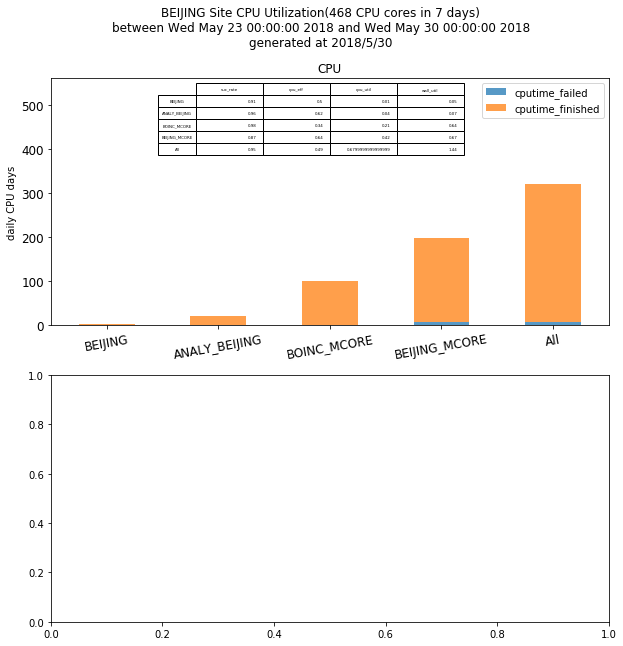

In [74]:
df=pd.DataFrame(site_res)
df["suc_rate"]=np.round(df["cn_finished"]/(df["cn_failed"]+df["cn_finished"]),2)
df["cpu_eff"]=np.round(df["cputime_finished"]/df["walltime_finished"],2)
df["cpu_util"]=np.round((df["cputime_finished"]+df["cputime_failed"])/avail_cpu,2)
df["wall_util"]=np.round((df["walltime_finished"]+df["walltime_failed"])/avail_cpu,2)

#rint(df)

avg_cn_rate=np.round(df["cn_finished"].sum()/(df["cn_failed"].sum()+df["cn_finished"].sum()),2)
avg_cpu_eff=np.round(df["cputime_finished"].sum()/df["walltime_finished"].sum(),2)
if "BOINC_MCORE" in df.index.values:
    grid_wall_util=np.round((df["walltime_finished"].sum()+df["walltime_failed"].sum()-df["walltime_finished"]["BOINC_MCORE"].sum()\
                             -df["walltime_failed"]["BOINC_MCORE"].sum())/avail_cpu,2)
    grid_cpu_util=np.round((df["cputime_finished"].sum()+df["cputime_failed"].sum()-df["cputime_finished"]["BOINC_MCORE"].sum()\
                            -df["cputime_failed"]["BOINC_MCORE"].sum())/avail_cpu,2)
    avg_cn_rate_grid=np.round((df["cn_finished"].sum()-df["cn_finished"]["BOINC_MCORE"].sum())\
                              /(df["cn_finished"].sum()+df["cn_failed"].sum()-\
                            df["cn_finished"]["BOINC_MCORE"].sum()-df["cn_failed"]["BOINC_MCORE"].sum()),2)
    grid_walltime_finished=np.round(df["walltime_finished"].sum()-df["walltime_failed"]["BOINC_MCORE"].sum(),2)
    grid_cputime_finished=np.round(df["cputime_finished"].sum()-df["cputime_failed"]["BOINC_MCORE"].sum(),2)
    grid_walltime_failed=np.round(df["walltime_failed"].sum()-df["walltime_failed"]["BOINC_MCORE"].sum(),2)
    grid_cputime_failed=np.round(df["cputime_finished"].sum()-df["cputime_failed"]["BOINC_MCORE"].sum(),2)
    total_cpu_util=grid_cpu_util+df["cpu_util"]["BOINC_MCORE"]
    total_wall_util=grid_wall_util+df["wall_util"]["BOINC_MCORE"]
else:
    grid_wall_util=np.round((df["walltime_finished"].sum()+df["walltime_failed"].sum())/avail_cpu,2)
    grid_cpu_util=np.round((df["cputime_finished"].sum()+df["cputime_failed"].sum())/avail_cpu,2)
    avg_cn_rate_grid=np.round(df["cn_finished"].sum()/(df["cn_finished"].sum()+df["cn_failed"].sum()),2)
    grid_walltime_finished=np.round(df["walltime_finished"].sum(),2)
    grid_cputime_finished=np.round(df["cputime_finished"].sum(),2)
    grid_walltime_failed=np.round(df["walltime_failed"].sum(),2)
    grid_cputime_failed=np.round(df["cputime_failed"].sum(),2)
    total_cpu_util=grid_cpu_util
    total_wall_util=grid_wall_util

avg_cpu_eff_grid=np.round(grid_cputime_finished/grid_walltime_finished,2)    
#total_cpu_util=np.round((df["cputime_finished"].sum()+df["cputime_failed"].sum())/avail_cpu,2)

                           
    #print(avg_cn_rate,total_cpu_util,avg_cpu_eff,grid_wall_util)
all_walltime_finished=df["walltime_finished"].sum()
all_walltime_failed=df["walltime_failed"].sum()
all_cputime_finished=df["cputime_finished"].sum()
all_cputime_failed=df["cputime_failed"].sum()

tmp_grid={"suc_rate":{"grid":avg_cn_rate_grid},"cpu_eff":{"grid":avg_cpu_eff_grid},"cpu_util":{"grid":grid_cpu_util},\
     "wall_util":{"grid":grid_wall_util},"cputime_finished":{"grid":grid_cputime_finished},\
     "cputime_failed":{"grid":grid_cputime_failed},"walltime_finished":{"grid":grid_walltime_finished},\
     "walltime_failed":{"grid":grid_walltime_failed}}

tmp_all={"suc_rate":{"All":avg_cn_rate},"cpu_eff":{"All":avg_cpu_eff},"cpu_util":{"All":total_cpu_util},\
     "wall_util":{"All":total_wall_util},"cputime_finished":{"All":all_cputime_finished},\
     "cputime_failed":{"All":all_cputime_failed},"walltime_finished":{"All":all_walltime_finished},\
     "walltime_failed":{"All":all_walltime_failed}}
df=pd.concat([df,pd.DataFrame(tmp_all)])


if "BOINC_MCORE"  in df.index.values:
    df_2c=pd.concat([df.loc["BOINC_MCORE":"BOINC_MCORE",],pd.DataFrame(tmp_grid),pd.DataFrame(tmp_all)])
else:
    df_2c=pd.concat([pd.DataFrame(tmp_grid),pd.DataFrame(tmp_all)])


dfes=[df[["cputime_failed","cputime_finished"]],df[["walltime_failed","walltime_finished"]],\
      df[["suc_rate","cpu_eff","cpu_util","wall_util"]]]


l=time.localtime()[0:3]
today="/".join(map(str,l))

#font = {'size'   : 12}
#plt.rc('font', **font)
fig, axes = plt.subplots(2,1)
sup="%s Site CPU Utilization(%d CPU cores in %d days)\nbetween %s and %s\ngenerated at %s"\
                            %(this_site, avail_cpu,last_days,time.ctime(stime/1000),time.ctime(etime/1000),today)
table_title1="%s Site CPU Utilization(%d CPU cores in %d days)"%(this_site, avail_cpu,last_days)
table_title2="%s to %s"%(time.ctime(stime/1000),time.ctime(etime/1000))
plt.suptitle(sup)
for i in [0]:
    tag="Wall"
    if i==0:
        tag="CPU"
        dfes[i]=dfes[i].sort_values(by="cputime_finished")
    else:
        dfes[i]=dfes[i].sort_values(by="walltime_finished")
    ylim=avail_cpu*1.2   
    fwidth=len(dfes[i].index.values)*2
    if fwidth<10:
        fwidth=10
    dfes[i].plot(ax=axes[i],kind="bar",stacked=True,grid=False,figsize=(fwidth,10),rot=1,fontsize=12,title=tag,alpha=0.75,ylim=(0,ylim))
    if i==0:
        dfes[2]=dfes[2].sort_values(by="cpu_util")
        table(axes[i],dfes[2],loc="upper center",colWidths=[0.12]*len(dfes[2].columns),rowLoc="center")
    axes[i].set_ylabel("daily %s days"%tag)
    axes[i].set_xticklabels(dfes[i].index.values,rotation=10 )
fig.savefig("plots/%s_site_%s_%s.png"%(this_site,last_days,end_days_ago))




In [75]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
df_res=pd.concat([dfes[0],dfes[1],dfes[2]],axis=1,join="outer")
df_res=df_res.sort_values(by="cpu_util")
printmd("**"+table_title1+"**")
printmd("*"+table_title2+"*")
df_res

**BEIJING Site CPU Utilization(468 CPU cores in 7 days)**

*Wed May 23 00:00:00 2018 to Wed May 30 00:00:00 2018*

,cputime_failed,cputime_finished,walltime_failed,walltime_finished,suc_rate,cpu_eff,cpu_util,wall_util
BEIJING,0.0,3.0,18.0,6.0,0.91,0.50,0.01,0.05
ANALY_BEIJING,0.0,20.0,2.0,32.0,0.96,0.62,0.04,0.07
BOINC_MCORE,0.0,100.0,3.0,298.0,0.98,0.34,0.21,0.64
BEIJING_MCORE,8.0,190.0,17.0,298.0,0.87,0.64,0.42,0.67
All,8.0,313.0,40.0,634.0,0.95,0.49,0.68,1.44


In [76]:
printmd("**"+table_title1+"**")
printmd("*"+table_title2+"*")
dfes[2]=dfes[2].sort_values(by="cpu_util")
dfes[2]

**BEIJING Site CPU Utilization(468 CPU cores in 7 days)**

*Wed May 23 00:00:00 2018 to Wed May 30 00:00:00 2018*

,suc_rate,cpu_eff,cpu_util,wall_util
BEIJING,0.91,0.50,0.01,0.05
ANALY_BEIJING,0.96,0.62,0.04,0.07
BOINC_MCORE,0.98,0.34,0.21,0.64
BEIJING_MCORE,0.87,0.64,0.42,0.67
All,0.95,0.49,0.68,1.44


In [77]:
printmd("**"+table_title1+"**")
printmd("*"+table_title2+"*")
df_2c=df_2c.rename(index={"BOINC_MCORE":"BOINC","grid":"Grid"})
df_2c[["suc_rate","cpu_eff","cpu_util","wall_util"]]

**BEIJING Site CPU Utilization(468 CPU cores in 7 days)**

*Wed May 23 00:00:00 2018 to Wed May 30 00:00:00 2018*

,suc_rate,cpu_eff,cpu_util,wall_util
BOINC,0.98,0.34,0.21,0.64
Grid,0.94,0.50,0.47,0.80
All,0.95,0.49,0.68,1.44
